In [15]:
import numpy as np
from numba import cfunc, vectorize
from numba.types import intc, CPointer, float64
from scipy import LowLevelCallable
from scipy.integrate import quad
from scipy.optimize import minimize_scalar
from matplotlib.colors import LogNorm
import os
import pickle

from pointlike_clump import dphi_de_e_pt, dphi_de_e_dampe_pt, lum_dampe_pt
from pointlike_clump import dphi_de_gamma_pt, dphi_de_gamma_dampe_pt
from pointlike_clump import constrain_ep_spec_pt
from background_models import bg_dampe
from constants import plot_obs, dampe_es, dampe_excess_iflux, fermi_psf
from constants import dampe_excess_bin_low, dampe_excess_bin_high
from constants import speed_of_light, kpc_to_cm
from finite_clump import dphi_de_e, rhos_dampe, dphi_de_e_dampe, dphi_de_gamma_dampe
from finite_clump import J_factor, lum_dampe, rho_NFW, dphi_de_gamma, lum_to_rhos
from finite_clump import gamma_ray_extent, constrain_ep_spec

colors = [c["color"] for c in plt.rcParams['axes.prop_cycle']]

# Plots

## Clump luminosity
WARNING: making $r_s$ too small (in practice, less than about 0.001 kpc for $d \sim 1$ kpc) leads to numerical problems in the luminosity and $J$ factor integrals.

In [2]:
ds = np.linspace(0.1, 1.5, 10)
rss = np.logspace(-3, -1, 3)

In [3]:
lums_pt = np.array([lum_dampe_pt(d, bg_dampe) for d in ds])

In [4]:
lums = {}

for rs in rss:
    lums[rs] = np.array([lum_dampe(d, rs, bg_dampe) for d in ds])

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best wh

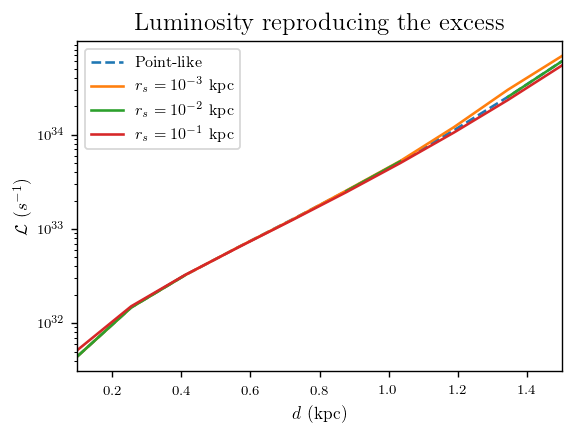

In [8]:
plt.plot(ds, lums_pt, '--', label='Point-like')
for rs in rss:
    plt.plot(ds, lums[rs], label=r'$r_s = 10^{%i}$ kpc' % np.log10(rs))

plt.xlim(ds[[0, -1]])
plt.yscale("log")
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$\mathcal{L}~(s^{-1})$")
plt.legend()
plt.title("Luminosity reproducing the excess")

plt.savefig('figures/lum.pdf', bbox_inches='tight')

## $e^+ + e^-$ spectrum

In [82]:
clump_e_fluxes = {}
pt_e_fluxes = {}

e_es = np.logspace(np.log10(1300), np.log10(1550), 150)

for d in [0.1, 0.3]:
    clump_e_fluxes[d] = dphi_de_e_dampe(e_es, d, 1.5, bg_dampe, gamma=0.5)
    pt_e_fluxes[d] = dphi_de_e_dampe_pt(e_es, d, bg_dampe)

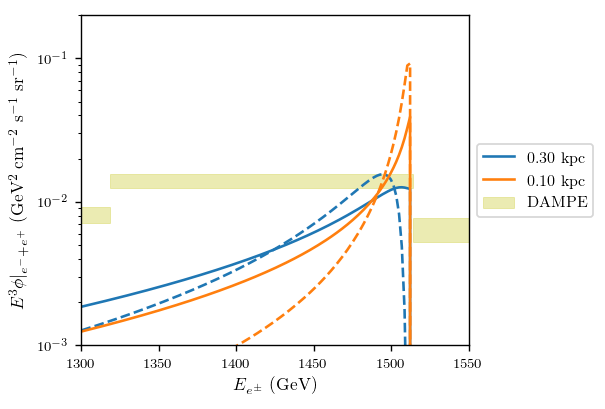

In [83]:
power = 3

plot_obs(power, highlight_excess_bins=False)

for d, c in zip(clump_e_fluxes.iterkeys(), colors):
    plt.plot(e_es, e_es**power * 2*clump_e_fluxes[d],
             label="%.2f kpc" % d, color=c)
    plt.plot(e_es, e_es**power * 2*pt_e_fluxes[d],
             '--', color=c)

plt.xlim(1300, 1550)
plt.ylim(1e-3, 2e-1)
# plt.xscale("log")
plt.yscale("log")

plt.xlabel(r"$E_{e^\pm}$ (GeV)")
plt.ylabel(r"$E^%i \phi|_{e^-+e^+}$ (GeV$^{%i}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$)" %
           (power, power - 1))

# Shrink current axis by 20%
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# plt.savefig('figures/ep_spectrum.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

## $\gamma$ spectrum
WARNING: making $r_s$ too small (in practice, less than about 0.001 kpc for $d \sim 1$ kpc) leads to numerical problems in the luminosity and $J$ factor integrals.

### Flux at 10 GeV as a function of $d$ and $r_s$

In [85]:
clump_10GeV_fluxes_d = {}

e_gammas = np.logspace(np.log10(1300), np.log10(1550), 150)
ds = np.logspace(-2, 0, 50) # kpc
rss = np.logspace(-3, -1, 3)
e_gamma_benchmark = 10. # GeV

In [86]:
for rs in rss:
    clump_10GeV_fluxes_d[rs] = np.array([dphi_de_gamma_dampe([e_gamma_benchmark],
                                                             np.cos(fermi_psf),
                                                             d, rs, bg_dampe)
                                       for d in ds]).flatten()

pt_10GeV_fluxes = np.array([dphi_de_gamma_dampe_pt([e_gamma_benchmark], d, bg_dampe)
                            for d in ds]).flatten()

In [ ]:
power = 0

plt.plot(ds, e_gamma_benchmark**power * pt_10GeV_fluxes_d, '--', label="Point-like")
for rs in rss:
    plt.plot(ds, e_gamma_benchmark**power * clump_10GeV_fluxes_d[rs],
             label=r"$r_s = 10^{%i}$ kpc" % np.log10(rs))

plt.xlim(ds[[0, -1]])
plt.xscale("log")
plt.yscale("log")

plt.title("Photon flux from DM clump")
plt.xlabel(r"$d$ (kpc)")
if power == 0:
    plt.ylabel(r"$\phi|_{\gamma}(E_\gamma = %i)$ (GeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$)"
               % e_gamma_benchmark)
else:
    plt.ylabel((r"$E^%i \phi|_{\gamma}(E_\gamma = %i)$ "
                r"(GeV$^{%i}$ cm$^2$ $s$ $sr$)$^{-1}$") 
               % (e_gamma_benchmark, power, 1-power))

box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('figures/gamma_ray_flux_d.pdf',
            bbox_extra_artists=(lgd,), bbox_inches='tight')

### Flux at 10 GeV as a function of $\Delta\Omega$

In [56]:
clump_10GeV_fluxes_dOmegas = {}

e_gammas = np.logspace(np.log10(1300), np.log10(1550), 150) # GeV
rss = np.logspace(-3, -1, 3) # kpc
thetas = np.logspace(np.log10(fermi_psf)-1, 0, 100) # rad
dOmegas = 2.*np.pi*(1. - np.cos(thetas)) # sr
e_gamma_benchmark = 10. # GeV

In [57]:
for rs in rss:
    clump_10GeV_fluxes_dOmegas[rs] = np.array(dphi_de_gamma_dampe([e_gamma_benchmark],
                                                                   np.cos(thetas),
                                                                   1., rs,
                                                                  bg_dampe)).flatten()

pt_10GeV_fluxes_dOmegas = np.array(len(thetas) * 
                                   [dphi_de_gamma_dampe_pt([e_gamma_benchmark],
                                                           1., bg_dampe)]).flatten()

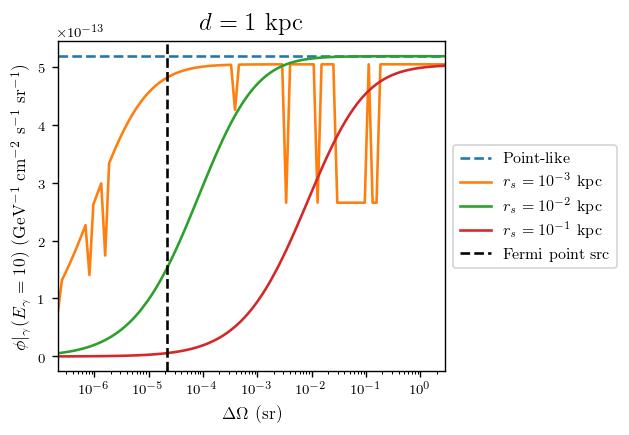

In [60]:
power = 0

plt.plot(dOmegas,
         e_gamma_benchmark**power * pt_10GeV_fluxes_dOmegas,
         '--', label="Point-like")
for rs in rss:
    plt.plot(dOmegas,
             e_gamma_benchmark**power * clump_10GeV_fluxes_dOmegas[rs],
             label=r"$r_s = 10^{%i}$ kpc" % np.log10(rs))

# Solid angle corresponding to Fermi's PSF
plt.axvline(2.*np.pi*(1.-np.cos(fermi_psf)),
            color='k', linestyle="dashed", label="Fermi point src")

plt.xlim(dOmegas[[0, -1]])
plt.xscale("log")
plt.title(r"$d=1$ kpc")
plt.xlabel(r"$\Delta\Omega$ (sr)")
if power == 0:
    plt.ylabel(r"$\phi|_{\gamma}(E_\gamma = %i)$ (GeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$)"
               % e_gamma_benchmark)
else:
    plt.ylabel((r"$E^%i \phi|_{\gamma}(E_\gamma = %i)$ "
                r"(GeV$^{%i}$ cm$^2$ $s$ $sr$)$^{-1}$") 
               % (e_gamma_benchmark, power, 1-power))

box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('figures/gamma_ray_flux_dOmega.pdf',
            bbox_extra_artists=(lgd,), bbox_inches='tight')

## $\rho_s$

In [16]:
ds = np.linspace(0.01, 1, 100)
rhoss = np.array([rhos_dampe(d, 0.2, bg_dampe) for d in ds])

Text(0.5,1,'$r_s = 0.2$ kpc')

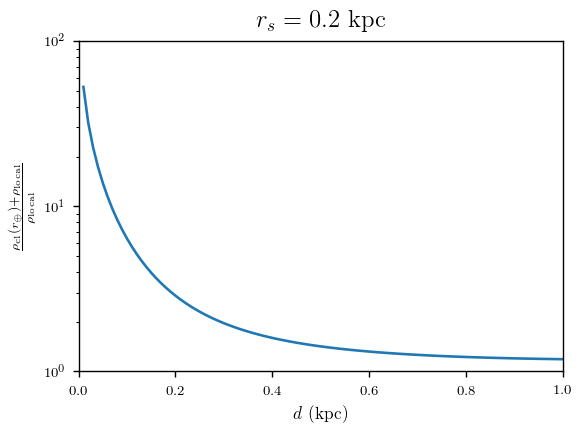

In [18]:
rho_local = 0.3

plt.plot(ds, [(rho_NFW(d, rs=0.1, rhos=rhos, gamma=0.5) + rho_local) / rho_local
              for d, rhos in zip(ds, rhoss)])

plt.yscale("log")
plt.xlim([0, 1])
plt.ylim(1e0, 1e2)

plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$\frac{\rho_{\mathrm{cl}}(r_\oplus) + \rho_{\mathrm{local}}}{\rho_{\mathrm{local}}}$")
plt.title(r"$r_s = 0.2$ kpc")

# plt.savefig('figures/rhos_rs_0.1.pdf', bbox_inches='tight')

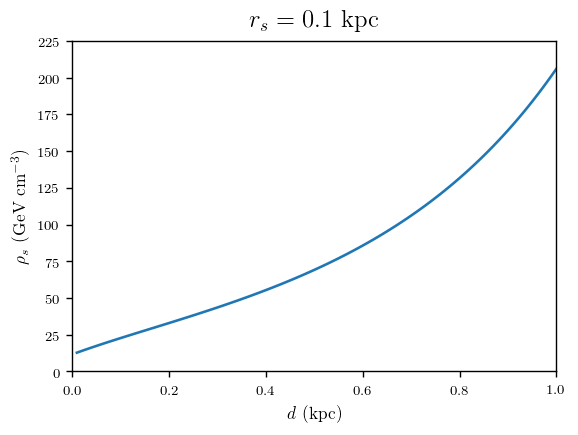

In [90]:
plt.plot(ds, rhoss)

plt.xlim([0, 1])
plt.ylim(0, 225)
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$\rho_s$ (GeV cm$^{-3}$)")
plt.title(r"$r_s = 0.1$ kpc")

plt.savefig('figures/rhos_rs_0.1.pdf', bbox_inches='tight')

# Contour plots

## $\mathcal{L}$

In [2]:
ds = np.logspace(-2, 0, 50)
rss = np.logspace(-2, -1, 50)

d_mg, rs_mg = np.meshgrid(ds, rss)

In [71]:
with open('data/ds.pkl', 'w') as f:
    pickle.dump(ds, f)

with open('data/rss.pkl', 'w') as f:
    pickle.dump(rss, f)

Clump luminosities

In [3]:
lums = np.array([[lum_dampe(d, rs, bg_dampe) for d in ds] for rs in rss])

with open('data/lums.pkl', 'w') as f:
    pickle.dump(lums, f)

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [3]:
with open('data/lums.pkl') as f:
    lums = pickle.load(f)

Point-like luminosities

In [198]:
lums_pt = np.array([[lum_dampe_pt(d, bg_dampe) for d in ds] for rs in rss])

with open('data/lums_pt.pkl', 'w') as f:
    pickle.dump(lums_pt, f)

In [4]:
with open('data/lums_pt.pkl') as f:
    lums_pt = pickle.load(f)

<a list of 8 text.Text objects>

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


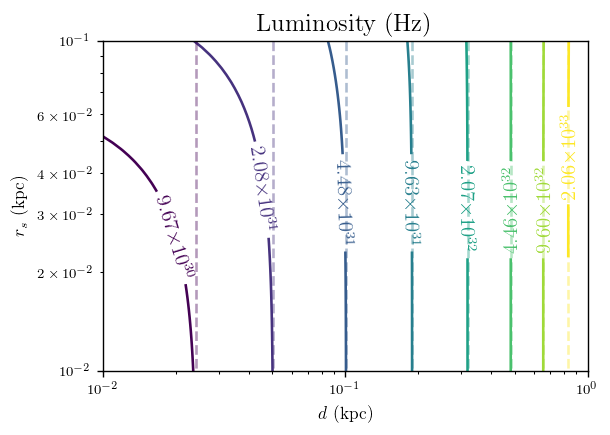

In [5]:
# Clump luminosities
lum_cs = plt.contour(d_mg, rs_mg, lums,
                     levels=np.logspace(np.log10(np.nanmin(lums)),
                                        np.log10(np.nanmax(lums)),
                                        10),
                     norm=LogNorm())
# Point-like luminosities
lum_pt_cs = plt.contour(d_mg, rs_mg, lums_pt,
                        levels=lum_cs.levels,
                        norm=LogNorm(),
                        alpha=0.4,
                        linestyles='dashed')

plt.xlim(ds[[0, -1]])
plt.ylim(rss[[0, -1]])
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$r_s$ (kpc)")
plt.xscale("log")
plt.yscale("log")
plt.title(r"Luminosity (Hz)")

# Format the contour labels
clabels_lums = {level: (r"%.2f" % (level / 10**np.floor(np.log10(level)))) +
                (r"$\times 10^{%i}$" % np.floor(np.log10(level)))
                for level in lum_cs.levels}
plt.clabel(lum_cs, inline=True, fmt=clabels_lums)

## $\rho_s$, $\frac{\rho_s + \rho_\oplus}{\rho_\oplus}$

Convert $\mathcal{L}$ to $\rho_s$ to avoid extra computations. Also compute relative enhancement to local DM density due to the clump.

In [5]:
rhoss = np.array([[lum_to_rhos(lum, dampe_excess_bin_high, rs) for lum in lum_list]
                  for lum_list, rs in zip(lums, rss)])

rho_rels = np.array([[rho_NFW(d, rs, rhos, 0.5) for rhos, d in zip(rhos_list, ds)]
                     for rhos_list, rs in zip(rhoss, rss)])

In [70]:
with open('data/rhoss.pkl', 'w') as f:
    pickle.dump(rhoss, f)

<a list of 6 text.Text objects>

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


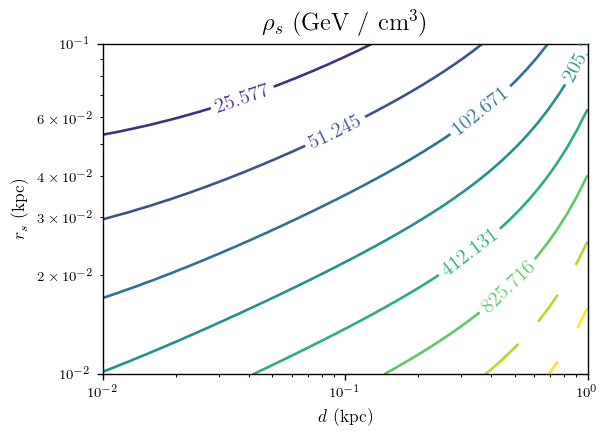

In [6]:
rhoss_cs = plt.contour(d_mg, rs_mg, rhoss,
                       levels=np.logspace(np.log10(np.nanmin(rhoss)),
                                          np.log10(np.nanmax(rhoss)),
                                          10),
                       norm=LogNorm())

plt.xlim(ds[[0, -1]])
plt.ylim(rss[[0, -1]])
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$r_s$ (kpc)")
plt.xscale("log")
plt.yscale("log")
plt.title(r"$\rho_s$ (GeV / cm$^3$)")

plt.clabel(rhoss_cs, inline=True)

<a list of 7 text.Text objects>

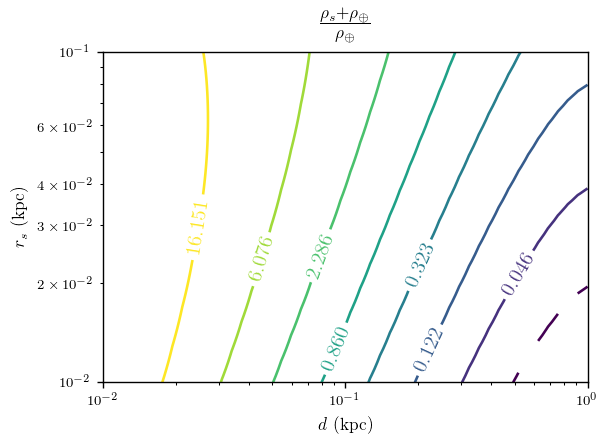

In [7]:
rho_rels_cs = plt.contour(d_mg, rs_mg, rho_rels,
                          levels=np.logspace(np.log10(np.nanmin(rho_rels)),
                                             np.log10(np.nanmax(rho_rels)),
                                             10),
                          norm=LogNorm())

plt.xlim(ds[[0, -1]])
plt.ylim(rss[[0, -1]])
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$r_s$ (kpc)")
plt.xscale("log")
plt.yscale("log")
plt.title(r"$\frac{\rho_s + \rho_\oplus}{\rho_\oplus}$")

plt.clabel(rho_rels_cs, inline=True)

## $\frac{d\phi_\gamma}{d E_\gamma} (E_\gamma = 10$ GeV)

Compute differential photon flux at $E_\gamma = 10$ GeV for clump and point-like cases.

In [8]:
e_gamma_ref = 10.

dpdeg_10GeVs = np.array([[dphi_de_gamma(e_gamma_ref, np.cos(fermi_psf), d,
                                        dampe_excess_bin_high, rs, rhos)
                          for rhos, d in zip(rhos_list, ds)]
                         for rhos_list, rs in zip(rhoss, rss)])

dpdeg_10GeVs_pt = np.array([[dphi_de_gamma_pt(e_gamma_ref, d, dampe_excess_bin_high, lum)
                             for lum, d in zip(lum_list, ds)]
                            for lum_list in lums_pt])

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


<a list of 6 text.Text objects>

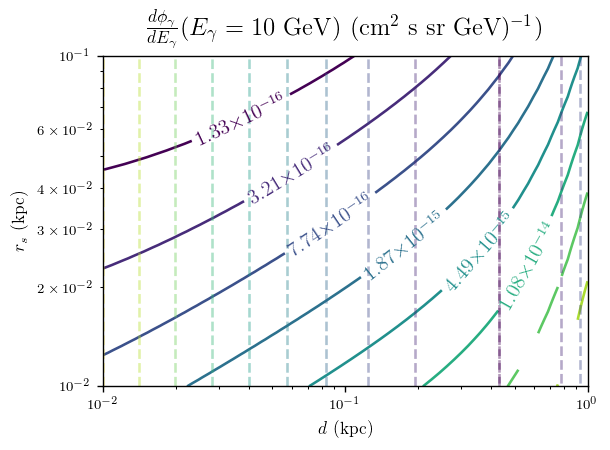

In [50]:
dpdeg_10GeVs_cs = plt.contour(d_mg, rs_mg, dpdeg_10GeVs,
                              levels=np.logspace(np.log10(np.nanmin(dpdeg_10GeVs)),
                                                 np.log10(np.nanmax(dpdeg_10GeVs)),
                                                 10),
                              norm=LogNorm())

# dpdeg_10GeVs_pt_cs = plt.contour(d_mg, rs_mg, dpdeg_10GeVs_pt,
#                                  levels=np.logspace(np.log10(np.nanmin(dpdeg_10GeVs_pt)),
#                                                     np.log10(np.nanmax(dpdeg_10GeVs_pt)),
#                                                     10),
#                                  norm=LogNorm(),
#                                  alpha=0.4,
#                                  linestyles='dashed')

plt.xlim(ds[[0, -1]])
plt.ylim(rss[[0, -1]])
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$r_s$ (kpc)")
plt.xscale("log")
plt.yscale("log")
plt.title(r"$\frac{d\phi_\gamma}{d E_\gamma}(E_\gamma=10~\mathrm{GeV})$ "
          r"(cm$^2$ s sr GeV)$^{-1})$")

# Format the contour labels
clabels_dpdeg_10GeVs = {level: (r"%.2f" % (level / 10**np.floor(np.log10(level)))) +
                (r"$\times 10^{%i}$" % np.floor(np.log10(level)))
                for level in dpdeg_10GeVs_cs.levels}
plt.clabel(dpdeg_10GeVs_cs, inline=True, fmt=clabels_dpdeg_10GeVs)

### Some horizontal slices through this plot

In [13]:
clump_10GeV_fluxes_d = {}

e_gammas = np.logspace(np.log10(1300), np.log10(1550), 150)
ds = np.logspace(-2, 0, 50) # kpc
rss = np.logspace(-3, -1, 3)
e_gamma_benchmark = 10. # GeV

for rs in rss:
    clump_10GeV_fluxes_d[rs] = np.array([dphi_de_gamma_dampe([e_gamma_benchmark],
                                                             np.cos(fermi_psf),
                                                             d, rs, bg_dampe)
                                       for d in ds]).flatten()

In [14]:
pt_10GeV_fluxes_d = np.array([dphi_de_gamma_dampe_pt([e_gamma_benchmark], d, bg_dampe)
                              for d in ds]).flatten()

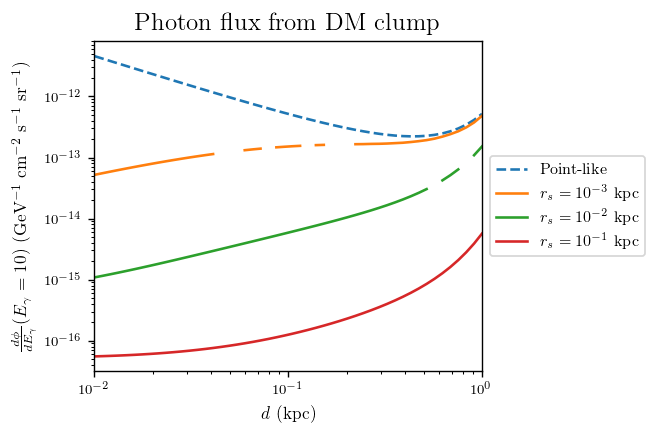

In [16]:
power = 0

plt.plot(ds, e_gamma_benchmark**power * pt_10GeV_fluxes_d, '--', label="Point-like")
for rs in rss:
    plt.plot(ds, e_gamma_benchmark**power * clump_10GeV_fluxes_d[rs],
             label=r"$r_s = 10^{%i}$ kpc" % np.log10(rs))

plt.xlim(ds[[0, -1]])
plt.xscale("log")
plt.yscale("log")

plt.title("Photon flux from DM clump")
plt.xlabel(r"$d$ (kpc)")
if power == 0:
    plt.ylabel(r"$\frac{d\phi}{dE_\gamma}(E_\gamma = %i)$ "
               "(GeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$)" % e_gamma_benchmark)
else:
    plt.ylabel((r"$E^%i \frac{d\phi}{dE_\gamma}(E_\gamma = %i)$ "
                r"(GeV$^{%i}$ cm$^2$ $s$ $sr$)$^{-1}$") % (e_gamma_benchmark,
                                                           power, 1-power))

box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## $\frac{\theta_{50\%}}{\theta_{\mathrm{Fermi}}}$

In [ ]:
extents = np.array([[gamma_ray_extent(10., d, dampe_excess_bin_high, rs, rhos)
                     for rhos, d in zip(rhos_list, ds)]
                    for rhos_list, rs in zip(rhoss, rss)])

with open('data/extents.pkl', 'w') as f:
    pickle.dump(extents, f)

In [13]:
with open('data/extents.pkl') as f:
    extents = pickle.load(f)

<a list of 7 text.Text objects>

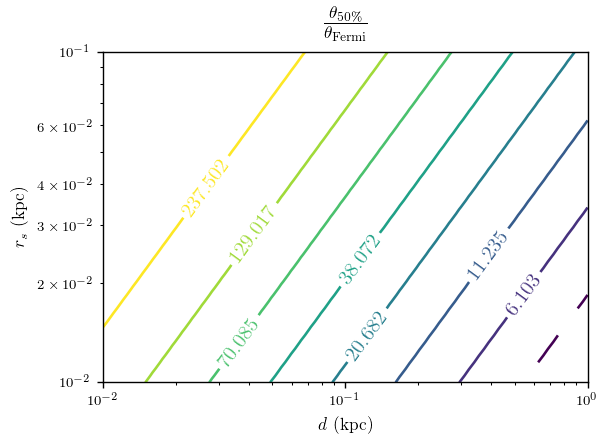

In [14]:
extents_cs = plt.contour(d_mg, rs_mg, extents / fermi_psf,
                         levels=np.logspace(np.log10(np.nanmin(extents / fermi_psf)),
                                            np.log10(np.nanmax(extents / fermi_psf)),
                                            10),
                         norm=LogNorm())

plt.xlim(ds[[0, -1]])
plt.ylim(rss[[0, -1]])
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$r_s$ (kpc)")
plt.xscale("log")
plt.yscale("log")
plt.title(r"$\frac{\theta_{50\%}}{\theta_{\mathrm{Fermi}}}$")


# Format the contour labels
plt.clabel(extents_cs, inline=True)

## Line width constraint

In [16]:
lw_contrs = np.array([[constrain_ep_spec(d, dampe_excess_bin_high, rs, rhos, bg_dampe)
                       for rhos, d in zip(rhos_list, ds)]
                      for rhos_list, rs in zip(rhoss, rss)])

In [18]:
lw_contrs_pt = np.array([[constrain_ep_spec_pt(d, dampe_excess_bin_high, lum, bg_dampe)
                          for lum, d in zip(lum_pt_list, ds)]
                         for lum_pt_list, rs in zip(lums_pt, rss)])

Text(0.5,1,'Line width constraint')

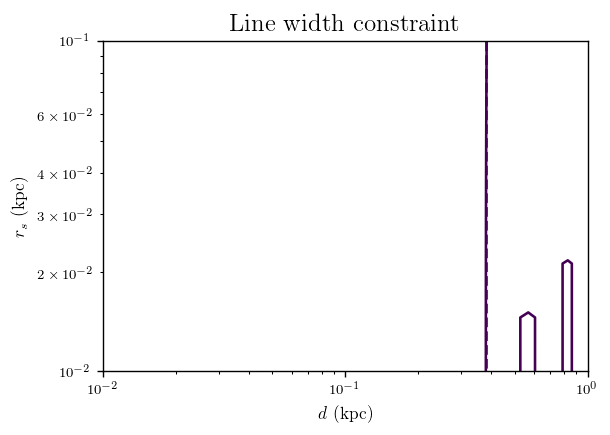

In [36]:
n_sigma = 3.

lw_contrs_cs = plt.contour(d_mg, rs_mg, lw_contrs,
                           levels=[n_sigma])

lw_contrs_pt_cs = plt.contour(d_mg, rs_mg, lw_contrs_pt,
                              levels=[n_sigma], linestyles='dashed')

plt.xlim(ds[[0, -1]])
plt.ylim(rss[[0, -1]])
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$r_s$ (kpc)")
plt.xscale("log")
plt.yscale("log")
plt.title(r"Line width constraint")

# Format the contour labels
# plt.clabel(lw_contrs_cs, inline=True)

Line width constraint is basically the same for a clump vs point-like source:

In [58]:
d_max_lw = ds[np.where(lw_contrs_pt[0, :] > 3)[0][0]]

## Plot everything together

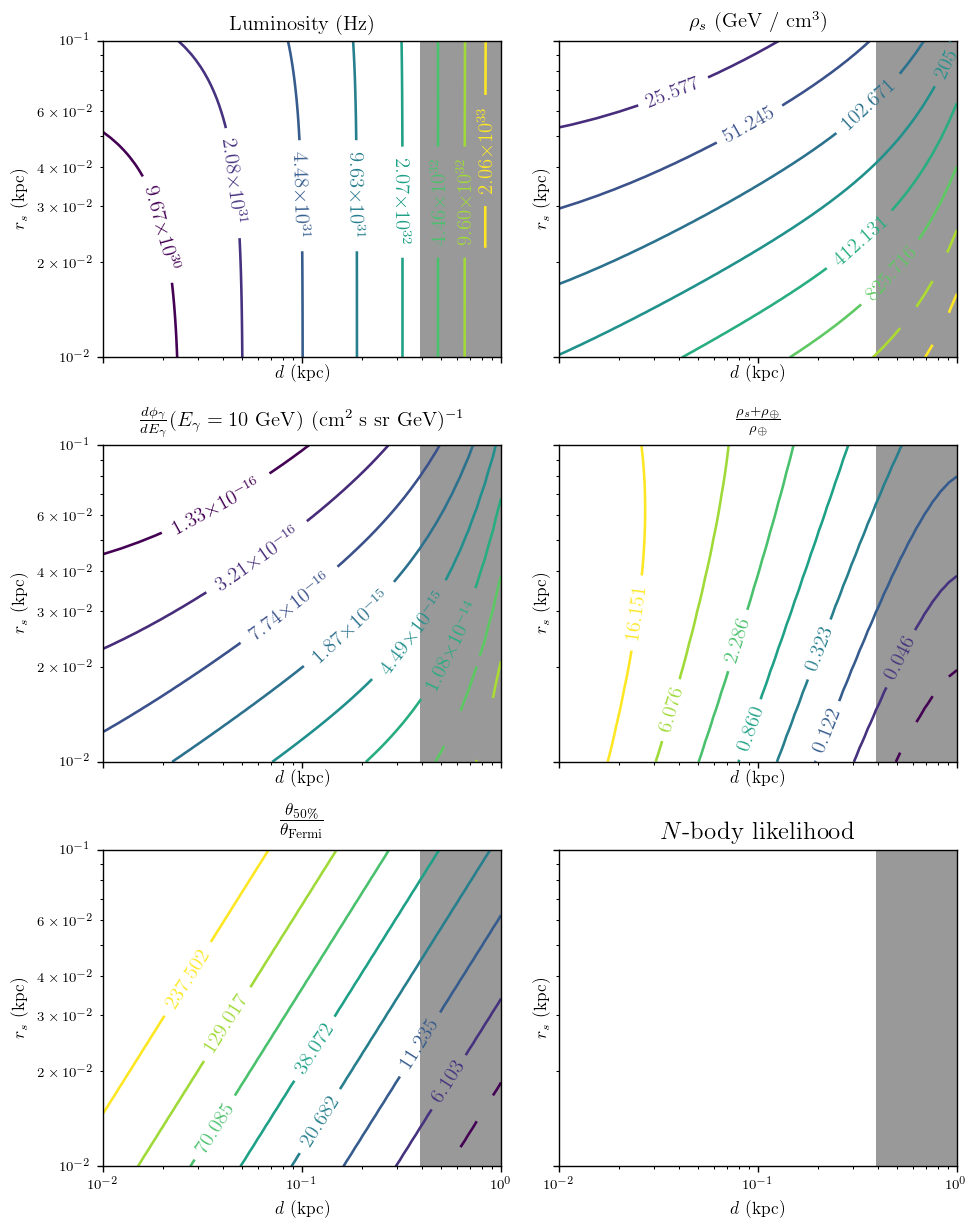

In [69]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True,
                        figsize=(8, 10))

for ax in axs.flatten():
    # Label axes
    ax.set_xlabel(r"$d$ (kpc)")
    ax.set_ylabel(r"$r_s$ (kpc)")
    # Line width constraint
    ax.axvspan(d_max_lw, ds[-1], color='k', linewidth=0, alpha=0.4)

### Luminosity
ax = axs[0, 0]
ax.set_title(r"Luminosity (Hz)", fontsize=12)

# Clump luminosities
lum_cs = ax.contour(d_mg, rs_mg, lums,
                    levels=np.logspace(np.log10(np.nanmin(lums)),
                                       np.log10(np.nanmax(lums)),
                                       10),
                    norm=LogNorm())

# Only need to do this once
ax.set_xlim(ds[[0, -1]])
ax.set_ylim(rss[[0, -1]])
ax.set_xscale("log")
ax.set_yscale("log")

# Format the contour labels
clabels_lums = {level: (r"%.2f" % (level / 10**np.floor(np.log10(level)))) +
                (r"$\times 10^{%i}$" % np.floor(np.log10(level)))
                for level in lum_cs.levels}
ax.clabel(lum_cs, inline=True, fmt=clabels_lums)

### Density normalization
ax = axs[0, 1]
ax.set_title(r"$\rho_s$ (GeV / cm$^3$)", fontsize=12)

rhoss_cs = ax.contour(d_mg, rs_mg, rhoss,
                      levels=np.logspace(np.log10(np.nanmin(rhoss)),
                                         np.log10(np.nanmax(rhoss)),
                                         10),
                      norm=LogNorm())

ax.clabel(rhoss_cs, inline=True)

### Contribution to local density
ax = axs[1, 1]
ax.set_title(r"$\frac{\rho_s + \rho_\oplus}{\rho_\oplus}$", fontsize=12)

rho_rels_cs = ax.contour(d_mg, rs_mg, rho_rels,
                         levels=np.logspace(np.log10(np.nanmin(rho_rels)),
                                            np.log10(np.nanmax(rho_rels)),
                                            10),
                         norm=LogNorm())

ax.clabel(rho_rels_cs, inline=True)

### Photon flux at E_gamma = 10 GeV
ax = axs[1, 0]
ax.set_title(r"$\frac{d\phi_\gamma}{d E_\gamma}(E_\gamma=10~\mathrm{GeV})$ "
             r"(cm$^2$ s sr GeV)$^{-1}$", fontsize=12)
dpdeg_10GeVs_cs = ax.contour(d_mg, rs_mg, dpdeg_10GeVs,
                             levels=np.logspace(np.log10(np.nanmin(dpdeg_10GeVs)),
                                                np.log10(np.nanmax(dpdeg_10GeVs)),
                                                10),
                             norm=LogNorm())

# Format the contour labels
clabels_dpdeg_10GeVs = {level: (r"%.2f" % (level / 10**np.floor(np.log10(level)))) +
                (r"$\times 10^{%i}$" % np.floor(np.log10(level)))
                for level in dpdeg_10GeVs_cs.levels}
ax.clabel(dpdeg_10GeVs_cs, inline=True, fmt=clabels_dpdeg_10GeVs)

### Angular extent of gamma rays
ax = axs[2, 0]
ax.set_title(r"$\frac{\theta_{50\%}}{\theta_{\mathrm{Fermi}}}$")
extents_cs = ax.contour(d_mg, rs_mg, extents / fermi_psf,
                         levels=np.logspace(np.log10(np.nanmin(extents / fermi_psf)),
                                            np.log10(np.nanmax(extents / fermi_psf)),
                                            10),
                         norm=LogNorm())

ax.clabel(extents_cs, inline=True)

### For Ben to do
axs[2, 1].set_title(r"$N$-body likelihood")

plt.tight_layout()

fig.savefig("figures/contour_plots.pdf")